## Calibration of a line to data

Simple demo demonstrating the workflow of `rxmc`.

In [1]:
import rxmc

Using database version X4-2024-12-31 located in: /home/beyerk/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [2]:
from collections import OrderedDict

import corner
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

## define parameters

In [3]:
help(rxmc.params.Parameter)

Help on class Parameter in module rxmc.params:

class Parameter(builtins.object)
 |  Parameter(name, dtype=<class 'float'>, unit='', latex_name=None)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, name, dtype=<class 'float'>, unit='', latex_name=None)
 |      Parameters:
 |          name (str): Name of the parameter
 |          dtype (np.dtype): Data type of the parameter
 |          unit (str): Unit of the parameter
 |          latex_name (str): LaTeX representation of the parameter
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables
 |  
 |  __weakref__
 |      list of weak references to the object



In [4]:
params = [
    rxmc.params.Parameter("b", float, "y-units"),
    rxmc.params.Parameter("m", float, "no-units"),
]

## make the model

In [5]:
help(rxmc.model.Model)

Help on class Model in module rxmc.model:

class Model(builtins.object)
 |  Model(x: numpy.ndarray)
 |  
 |  Represents an arbitrary parameteric model
 |  
 |  Methods defined here:
 |  
 |  __call__(self, params: collections.OrderedDict)
 |      Call self as a function.
 |  
 |  __init__(self, x: numpy.ndarray)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables
 |  
 |  __weakref__
 |      list of weak references to the object



In [6]:
class LinearModel(rxmc.model.Model):
    def __call__(self, params: OrderedDict):
        return params["m"] * self.x + params["b"]

In [7]:
x = np.linspace(0, 1, 10)

In [8]:
my_model = LinearModel(x)

## define a prior

In [9]:
prior_mean = OrderedDict(
    [
        ("m", 1),
        ("b", 1),
    ]
)
prior_std_dev = OrderedDict(
    [
        ("m", 1),
        ("b", 1),
    ]
)

In [10]:
covariance = np.diag(list(prior_std_dev.values())) ** 2
mean = np.array(list(prior_mean.values()))

In [11]:
n_prior_samples = 100000
prior_distribution = stats.multivariate_normal(mean, covariance)
prior_samples = prior_distribution.rvs(size=n_prior_samples)

In [12]:
y = np.zeros((n_prior_samples, len(my_model.x)))
for i in range(n_prior_samples):
    sample = prior_samples[i, :]
    y[i, :] = my_model(rxmc.params.to_ordered_dict(sample, [p.name for p in params]))

upper, lower = np.percentile(y, [5, 95], axis=0)

Text(0.5, 1.0, 'prior')

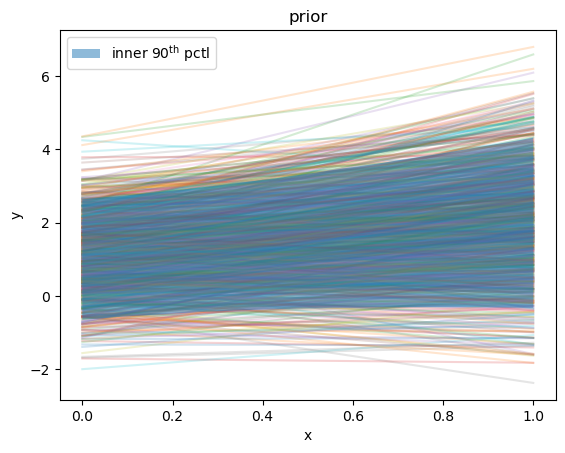

In [13]:
for i in np.random.choice(n_prior_samples, 1000):
    plt.plot(my_model.x, y[i, :], zorder=1, alpha=0.2)
    # pass

plt.fill_between(
    my_model.x, lower, upper, alpha=0.5, zorder=2, label=r"inner 90$^\text{th}$ pctl"
)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("prior")

Text(0.5, 0.98, 'prior')

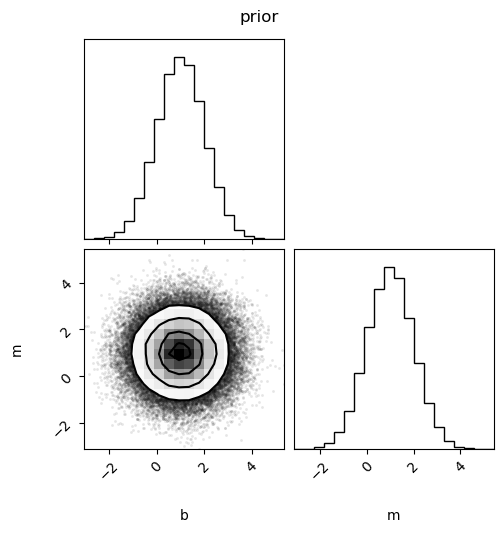

In [14]:
fig = corner.corner(prior_samples, labels=[p.name for p in params])
fig.suptitle("prior")

## find some data
In our case we will synthetically generate some data with noise about a "true" `m` and `b`. Our calibration posterior should converge to be centered about this true point.

Let us assume that the experimentalists made a perfect estimate of the experimental noise in their setup. That is, the error bars they report will correspond exactly to the true distribution from which we sample.

This noise will correspond to statistical noise. Later on we will look at systematic experimental error.

In [15]:
rng = np.random.default_rng(13)

Text(0.5, 1.0, 'experimental constraint')

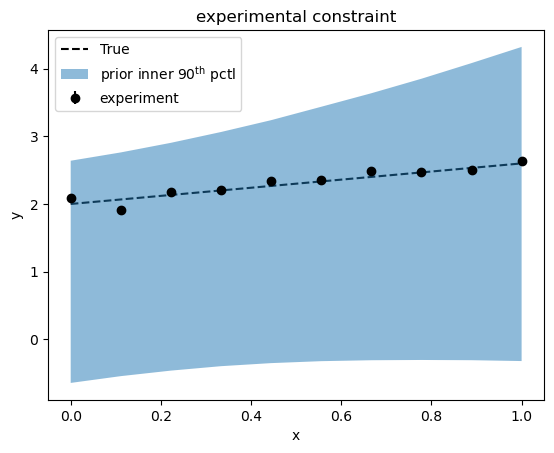

In [16]:
true_params = OrderedDict(
    [
        ("m", 0.6),
        ("b", 2),
    ]
)

noise = 0.05
y_exp = my_model(true_params) + rng.normal(scale=noise, size=len(my_model.x))
y_exp_err = noise * np.ones_like(y_exp)  # noise is just a constant fraction of y
plt.errorbar(
    my_model.x,
    y_exp,
    y_exp_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment",
)
plt.plot(my_model.x, my_model(true_params), "k--", label=True)
plt.xlabel("x")
plt.ylabel("y")

plt.fill_between(
    my_model.x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"prior inner 90$^\text{th}$ pctl",
)

plt.legend()
plt.title("experimental constraint")

## set up constraint

In [17]:
help(rxmc.constraint.FixedCovarianceConstraint)

Help on class FixedCovarianceConstraint in module rxmc.constraint:

class FixedCovarianceConstraint(Constraint)
 |  FixedCovarianceConstraint(y: numpy.ndarray, covariance: numpy.ndarray, model: rxmc.model.Model)
 |  
 |  A special case of Constraint in which the covariance matrix is known a
 |  priori; e.g. is not dependent on the Model or its params
 |  
 |  Parameters
 |  ----------
 |  covariance : np.ndarray
 |      Covariance matrix.
 |  cov_inc : np.ndarray
 |      inverse of covariance matrix.
 |  log_det : np.ndarray
 |      log determinant of covariance matrix
 |  
 |  Method resolution order:
 |      FixedCovarianceConstraint
 |      Constraint
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, y: numpy.ndarray, covariance: numpy.ndarray, model: rxmc.model.Model)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  chi2(self, params: collections.OrderedDict)
 |      Calculate the generalised chi-squared statistic. This is

In [18]:
constraint = rxmc.constraint.FixedCovarianceConstraint(
    y_exp,
    np.diag(y_exp_err**2),
    my_model,
)

## What is the reduced $\chi^2$ for the prior mean?

In [19]:
constraint.chi2(
    rxmc.params.to_ordered_dict(prior_distribution.mean, [p.name for p in params])
) / constraint.n_data_pts

np.float64(274.7942520863856)

In [20]:
constraint.log_det

np.float64(-59.914645471079815)

In [21]:
np.log((noise**2) ** constraint.n_data_pts)

np.float64(-59.914645471079815)

## running the calibration

In [22]:
help(rxmc.mcmc.run_chain)

Help on function run_chain in module rxmc.mcmc:

run_chain(prior, corpus: rxmc.corpus.Corpus, nsteps: int, burnin: int = 0, seed: int = 42, batch_size: int = None, rank: int = 0, proposal_cov_scale_factor: float = 100, verbose: bool = True, output: pathlib.Path = None)
    Runs the MCMC chain with the specified parameters.
    
    Parameters:
        prior (object): The prior distribution object with mean, cov attributes
            and a logpdf method.
        corpus (corpus.Corpus): The corpus object with a logpdf method.
        nsteps (int): Total number of steps for the MCMC chain.
        batch_size (int): Number of steps per batch.
        burnin (int): Number of initial steps to discard.
        seed (int): Random seed for generating random numbers.
        rank (int): MPI rank for the current process.
        proposal_cov_scale_factor (float): Scale factor for the proposal
            covariance.
        verbose (bool): Flag to print extra logging information.
        output 

First we need to make a Corpus. With one constraint this seems trivial, but this will be useful down the road when we may want to combine multiple constraints together.

In [23]:
help(rxmc.corpus.Corpus)

Help on class Corpus in module rxmc.corpus:

class Corpus(builtins.object)
 |  Corpus(constraints: list[rxmc.constraint.Constraint], params: list, model_name: str, corpus_name: str, weights: numpy.ndarray = None)
 |  
 |  A class to represent a generic collection of independent constraints.
 |  
 |  Attributes
 |  ----------
 |  model_name : str
 |      Name of model
 |  corpus_name : str
 |      label for corpus of constraints
 |  constraints : list of Constraint
 |      A list of constraints with the same model.
 |  y : np.ndarray
 |      Combined y values from all constraints.
 |  x : np.ndarray
 |      Combined x values from all constraints.
 |  n_data_pts : int
 |      Total number of data points.
 |  n_dof : int
 |      Total number of degrees of freedom in calibration.
 |  nparams : int
 |      Total number of free parameters in the model.
 |  params : list of str
 |      The parameter names
 |  weights : np.ndarray
 |      Weights for each constraint (should sum to 1)
 |  
 |  

In [24]:
corpus = rxmc.corpus.Corpus(
    [constraint],
    [p.name for p in params],
    "my_linear_model",
    "my_experimental_constraint",
)

In [25]:
%%time
# run a single chain
logl, chain, accepted_frac = rxmc.mcmc.run_chain(
    prior_distribution, corpus, nsteps=10000, burnin=1000, verbose=True
)

Rank: 0. Burn-in batch 1/1 completed, 1000 steps.
Rank: 0. Batch: 1/1 completed, 9000 steps. Acceptance frac: 0.111
CPU times: user 2.2 s, sys: 2.48 ms, total: 2.21 s
Wall time: 2.2 s


Text(0.5, 0, '$i$')

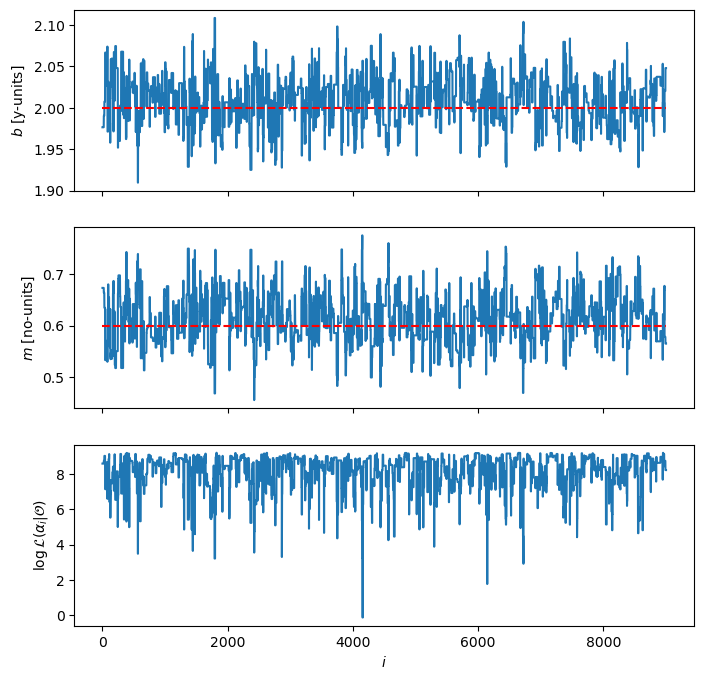

In [26]:
fig, axes = plt.subplots(chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True)
for i in range(chain.shape[1]):
    axes[i].plot(chain[:, i])
    axes[i].set_ylabel(f"${params[i].latex_name}$ [{params[i].unit}]")
    true_value = true_params[params[i].name]
    axes[i].hlines(true_value, 0, len(chain), "r", linestyle="--")


axes[-1].plot(logl)
axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

axes[-1].set_xlabel(r"$i$")
# plt.legend(title="chains", ncol=3,)

In [27]:
posterior_range = np.vstack([np.min(chain, axis=0), np.max(chain, axis=0)]).T

In [28]:
true_params.values()

odict_values([0.6, 2])

Text(0.5, 0.98, 'posterior')

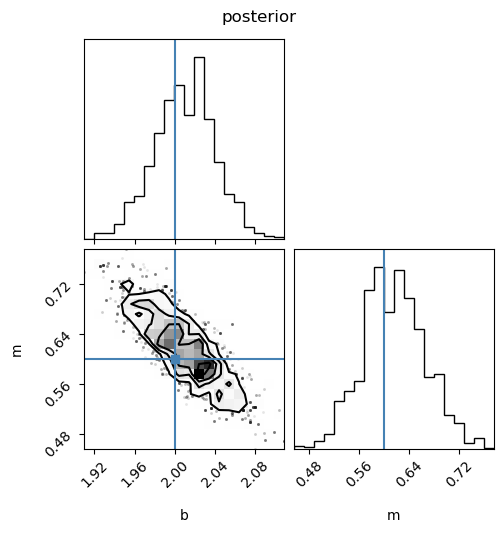

In [29]:
fig = corner.corner(
    chain,
    labels=[p.name for p in params],
    label="posterior",
    truths=[true_params["b"], true_params["m"]],
)
fig.suptitle("posterior")

In [30]:
n_posterior_samples = chain.shape[0]
y = np.zeros((n_posterior_samples, len(my_model.x)))
for i in range(n_posterior_samples):
    sample = chain[i, :]
    y[i, :] = my_model(rxmc.params.to_ordered_dict(sample, [p.name for p in params]))

upper, lower = np.percentile(y, [5, 95], axis=0)

Text(0.5, 1.0, 'predictive posterior')

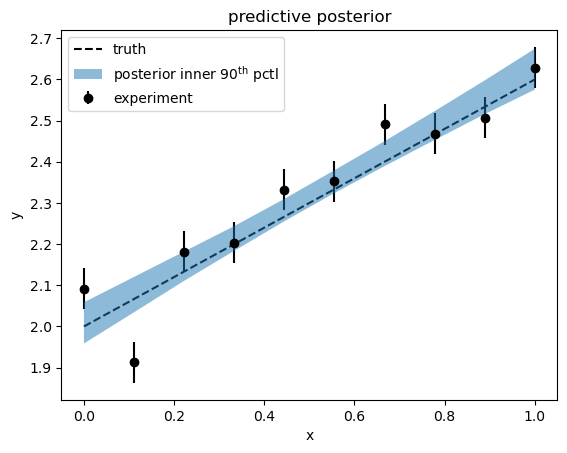

In [31]:
plt.plot(my_model.x, my_model(true_params), "k--", label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.errorbar(
    my_model.x,
    y_exp,
    y_exp_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment",
)
plt.fill_between(
    my_model.x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"posterior inner 90$^\text{th}$ pctl",
)

plt.legend()
plt.title("predictive posterior")

True applications should run multiple chains with different random seeds and starting locations to avoid autocorrelation within a chain.